## **Install Dependencies**

In [5]:
 !pip install -q datasets transformers peft accelerate bitsandbytes

## **Basic Imports**

In [7]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import torch

## **Load dataset & Tokenizer**

In [ ]:
# Load dataset
dataset = load_dataset("Abirate/english_quotes")
#split 90% train / 10% validation without overlap
dataset_split = dataset["train"].train_test_split(test_size=0.1, seed=42)

train_data = dataset_split["train"]
val_data = dataset_split["test"]

# Load tokenizer
model_name = "gpt2"
# AutoTokenizer picks the right tokenizer class automatically based on the model 
tokenizer = AutoTokenizer.from_pretrained(model_name)
# give GPT-2 a fake pad token so batching works during training
tokenizer.pad_token = tokenizer.eos_token

README.md: 0.00B [00:00, ?B/s]

quotes.jsonl:   0%|          | 0.00/647k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2508 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## **Tokenize**

In [9]:
# Tokenize + add labels
def tokenize(batch):
    tokenized = tokenizer(batch["quote"], padding="max_length", truncation=True, max_length=64)
    # It shifts the labels internally by 1 position when calculating the loss
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized
# batched = True -->> sends data in batches
train_data = train_data.map(tokenize, batched=True)
val_data = val_data.map(tokenize, batched=True)

Map:   0%|          | 0/2257 [00:00<?, ? examples/s]

Map:   0%|          | 0/251 [00:00<?, ? examples/s]

## **Load Model**

In [ ]:
# Load model in FP16
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    # device map -->> If I have multiple GPUs, it can split layers between them.
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## **LoRA config + Training arguments + training**

W_ft = W_pt + (alpha / r) * A * B   ### LoRA weight update
 ### W_pt  : pre-trained (frozen) weights
 ### A, B  : low-rank trainable matrices
 ### r     : rank of decomposition
 ### alpha : scaling factor


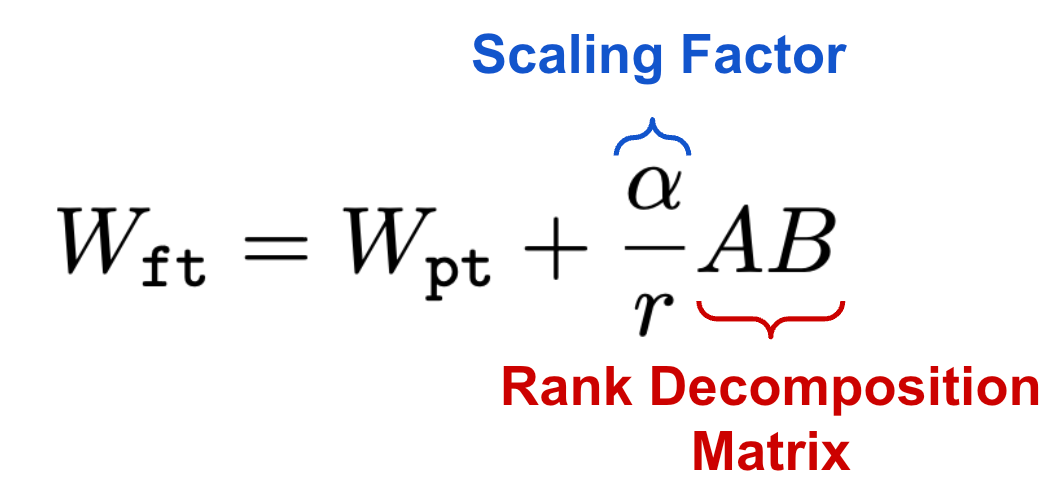
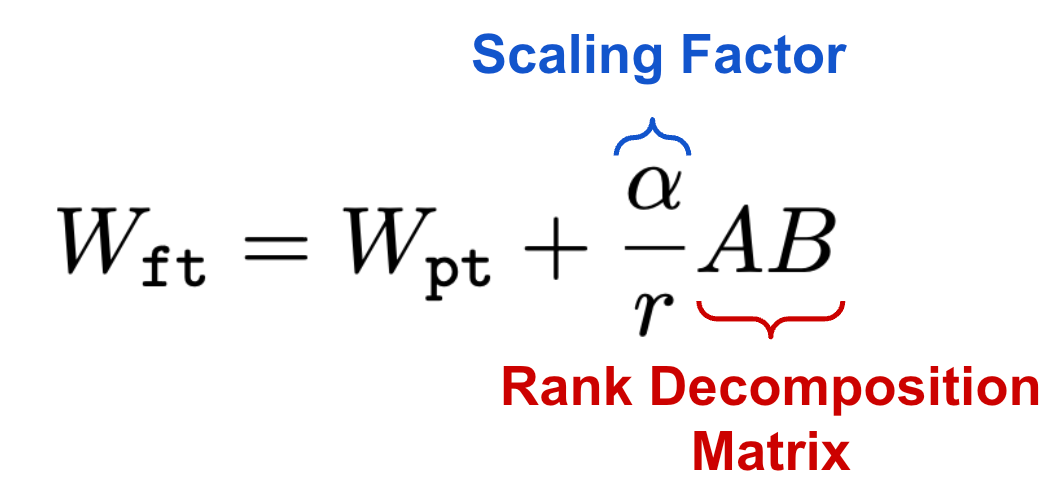

In [11]:
# LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["c_attn"],  # GPT-2 attention
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

In [12]:
# Inserts low-rank LoRA layers into those modules
model = get_peft_model(model, lora_config)


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1803: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [13]:
#  Training arguments
training_args = TrainingArguments(
    output_dir="./lora-llm",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    # batch_size=4, grad_accum_steps=2 → effective batch size = 4 × 2 = 8
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    eval_steps=20,
    logging_steps=10,
    save_steps=50,
    learning_rate=2e-4,
    num_train_epochs=5,
    fp16=True,
    report_to="none"
)


In [14]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer
)

/tmp/ipykernel_47/2951626966.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [15]:
# Train
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
20,5.488500,5.368277
40,3.109400,2.259604
60,2.133000,1.879649
80,1.965200,1.754850
100,1.700500,1.644678
120,1.644000,1.575485
140,1.704700,1.537865
160,1.857500,1.525085
180,1.908200,1.513901
200,1.765000,1.506125


TrainOutput(global_step=1415, training_loss=1.7522339871409924, metrics={'train_runtime': 257.3396, 'train_samples_per_second': 43.853, 'train_steps_per_second': 5.499, 'total_flos': 369863056097280.0, 'train_loss': 1.7522339871409924, 'epoch': 5.0})

## Save the model

In [16]:
#  Save LoRA adapter
model.save_pretrained("lora-gpt2")
tokenizer.save_pretrained("lora-gpt2")

('lora-gpt2/tokenizer_config.json',
 'lora-gpt2/special_tokens_map.json',
 'lora-gpt2/vocab.json',
 'lora-gpt2/merges.txt',
 'lora-gpt2/added_tokens.json',
 'lora-gpt2/tokenizer.json')

## Inference From Saved Model

In [17]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

#  Load tokenizer
base_model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained("lora-gpt2")
tokenizer.pad_token = tokenizer.eos_token

#  Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Load LoRA adapter
model = PeftModel.from_pretrained(base_model, "lora-gpt2")


In [18]:
#  Build pipeline
text_gen = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto"
)

Device set to use cuda:0


In [19]:
# Run inference
prompt = "The secret to happiness is"
outputs = text_gen(prompt, max_new_tokens=70, num_return_sequences=1, do_sample=True, temperature=0.7)

print(outputs[0]["generated_text"])

The secret to happiness is to be not ashamed of it. As for the secrets of life, they are as true to me as they are to my heart. The secrets of the mind are as true to me as they are to my heart. And so, in the end, and only in the end, shall I be happy. In the end, I shall not be


In [21]:
# Run inference
prompt = "There was a King"
outputs = text_gen(prompt, max_new_tokens=70, num_return_sequences=1, do_sample=True, temperature=0.7)

print(outputs[0]["generated_text"])

There was a King of Kings waiting at the end of the road. A great many of us were there, and we were all there with a view to meeting and seeing what was to come. We had been waiting for a long time, but couldn't seem to get in. It was a great deal heavier than we had thought, and we were all going to be
